# Data pre process

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
DataFrame = pd.read_excel('./DataSets/Building_energy.xlsx', header=1)

In [2]:
DataFrame.head()

,Time,reading
0,2021-01-27 11:00:00,8.03 kWh
1,2021-01-27 12:00:00,6.85 kWh
2,2021-01-27 13:00:00,8.86 kWh
3,2021-01-27 14:00:00,7.37 kWh
4,2021-01-27 15:00:00,7.67 kWh


In [3]:
DataFrame.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6726 entries, 0 to 6725
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Time     6726 non-null   object
 1   reading  6726 non-null   object
dtypes: object(2)
memory usage: 105.2+ KB


In [4]:
DataFrame.columns 

Index(['Time', 'reading'], dtype='object')

In [9]:
print(DataFrame['Time'])

0       2021-01-27 11:00:00
1       2021-01-27 12:00:00
2       2021-01-27 13:00:00
3       2021-01-27 14:00:00
4       2021-01-27 15:00:00
               ...         
6721    2021-11-03 12:00:00
6722    2021-11-03 13:00:00
6723    2021-11-03 14:00:00
6724    2021-11-03 15:00:00
6725    2021-11-03 16:00:00
Name: Time, Length: 6726, dtype: object


In [8]:
type(DataFrame['Time'][0])

str

* Changing the date info into a *datetime* type objetc, in order to be able to access to the values separately (we'll needed for the inputs of the model)

In [13]:
from datetime import datetime as dt 

dates=[]
    
for str_date in DataFrame['Time']: 
    #print(str_date)
    dt = dt.strptime(str_date, "%Y-%m-%d %H:%M:%S")
    dates.append(dt)


* Delete Time column and insert the new Time column

In [14]:
DataFrame.drop('Time', inplace = True, axis=1) 

#Insert the newone
DataFrame.insert(0, 'Time',dates)

#Check if it worked 
DataFrame.head()

,Time,reading
0,2021-01-27 11:00:00,8.03 kWh
1,2021-01-27 12:00:00,6.85 kWh
2,2021-01-27 13:00:00,8.86 kWh
3,2021-01-27 14:00:00,7.37 kWh
4,2021-01-27 15:00:00,7.67 kWh


* Removing Units from Reading column

In [16]:

reading  = [float(s.replace(" kWh",'')) for s in DataFrame['reading']]
#Insert the new values without the units
DataFrame.insert(1, 'Energy Usage',reading)

#Remove the old one
DataFrame.drop('reading', inplace = True, axis=1) 

#check 
DataFrame.head()

,Time,Energy Usage
0,2021-01-27 11:00:00,8.03
1,2021-01-27 12:00:00,6.85
2,2021-01-27 13:00:00,8.86
3,2021-01-27 14:00:00,7.37
4,2021-01-27 15:00:00,7.67


* Plot Energy Usage

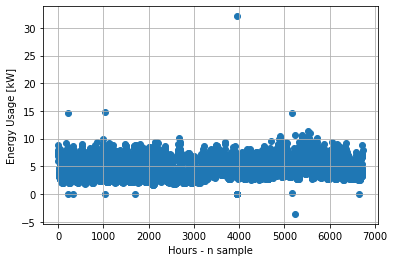

In [17]:
plt.scatter(DataFrame.index,DataFrame['Energy Usage'])
plt.xlabel('Hours - n sample')
plt.ylabel("Energy Usage [kW]")
plt.grid() 


<Figure size 432x288 with 0 Axes>

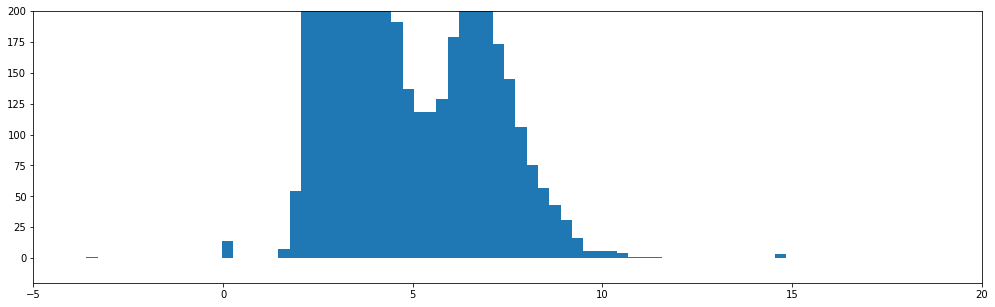

In [18]:
#We have to make it better, but later
plt.figure()
plt.figure(figsize=(17, 5))
plt.hist(DataFrame['Energy Usage'], bins=120) 

plt.xlim([-5,20])
plt.ylim([-20,200])
plt.show()
#looks like a Gaussian 

<Figure size 432x288 with 0 Axes>

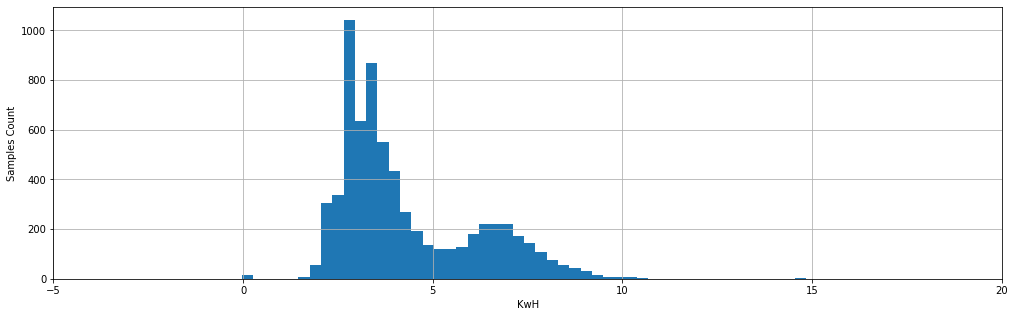

In [19]:
#We have to make it better, but later
plt.figure()
plt.figure(figsize=(17, 5))
plt.hist(DataFrame['Energy Usage'], bins=120) 
plt.xlabel("KwH")
plt.ylabel("Samples Count")
plt.grid('--')
plt.xlim([-5,20])
plt.show()

* Gaussian vs our *Energy Usage* distribution

<Figure size 432x288 with 0 Axes>

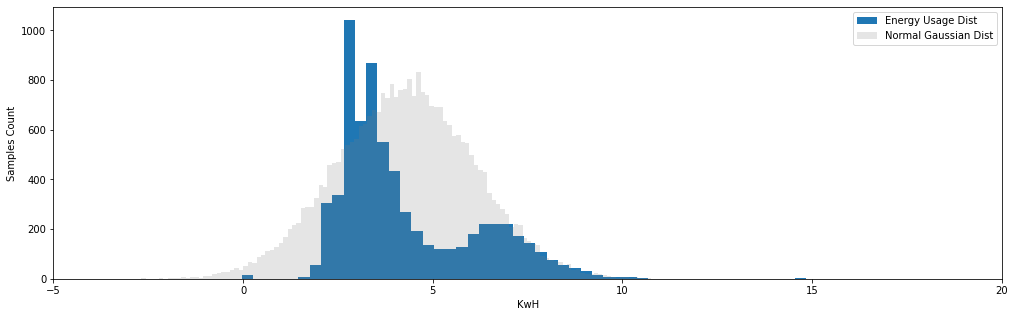

In [20]:
mu = np.mean(DataFrame['Energy Usage'])
std = np.std(DataFrame['Energy Usage'])

datos = np.random.normal(mu, std, 30000) #creando muestra de datos


plt.figure()
plt.figure(figsize=(17, 5))
plt.hist(DataFrame['Energy Usage'], bins=120, label="Energy Usage Dist")
plt.hist(datos,bins=120,alpha=.2,color='gray',lw=.75,linestyle=':',label="Normal Gaussian Dist")
#plot the limits and de mean 
#plt.plot(mu,1500)
#
plt.xlabel("KwH")
plt.ylabel("Samples Count")
plt.legend()
plt.xlim([-5,20])
plt.show()



### Finding the anomalies 

We've considered anomalies the data point outside of 4sigma of the normal gaussian distribution. 
More explanation ...


we consider 0 (not a oulier) as anamolie


In [21]:
def find_anomalies(data):
    #define a list to accumlate anomalies
    anomalies = []
    idx_anomalies = []
    
   
    # Set upper and lower limit to 3 standard deviation
    data_std = np.std(data)
    data_mean = np.mean(data)
    anomaly_cut_off = data_std * 4
    lower_limit  = data_mean - anomaly_cut_off 
    upper_limit = data_mean + anomaly_cut_off

    # Generate outliers
    for idx,outlier in enumerate(data):
        if outlier > upper_limit or outlier < lower_limit or outlier ==0: 
            anomalies.append(outlier)
            idx_anomalies.append(idx)
          
        
    return anomalies, idx_anomalies


In [22]:
anomalies, idx_anomalies = find_anomalies(DataFrame["Energy Usage"])
print(anomalies)
print(idx_anomalies)

[0.0, 14.7, 0.0, 0.0, 14.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.1, 14.7, -3.6, 0.0]
[217, 218, 320, 1034, 1035, 1695, 3949, 3950, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 5158, 5222, 6639]


### Interpolation 

as we have consecutives values considered anomalies, we can't do manually linear interpolation

In [24]:
def replace_anomalies(data,idx_anomalies,col): 
    for index in idx_anomalies: 
        #DataFrame["Energy Usage"][index] = DataFrame["Energy Usage"][index-1] +  DataFrame["Energy Usage"][index+1] / 2 
        data[col][index] = np.nan
        
    return data

In [25]:
DataFrame= replace_anomalies(DataFrame,idx_anomalies,'Energy Usage')

/tmp/ipykernel_8230/3520209725.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][index] = np.nan


In [26]:
DataFrame["Energy Usage"][3950:3955]

3950   NaN
3951   NaN
3952   NaN
3953   NaN
3954   NaN
Name: Energy Usage, dtype: float64

In [30]:
DataFrame.interpolate(method='ffill',inplace=True)

In [31]:
DataFrame["Energy Usage"][3950:3955]

3950    3.88
3951    3.88
3952    3.88
3953    3.88
3954    3.88
Name: Energy Usage, dtype: float64

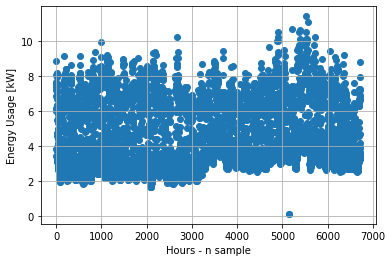

In [32]:
plt.scatter(DataFrame.index,DataFrame['Energy Usage'])
plt.xlabel('Hours - n sample')
plt.ylabel("Energy Usage [kW]")
plt.grid() 


* Identifying the week days 

In [35]:
weekday = [] 

for day in DataFrame['Time']: 
    weekday.append(day.weekday())

* Adding the new column

In [ ]:
DataFrame.insert(1, 'Week Day',weekday)

#Remove the old one
DataFrame.drop('reading', inplace = True, axis=1) 